<a href="https://colab.research.google.com/github/n-beckage/CS254_Final_Project/blob/main/NestedCV_rbf_poly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# README
This notebook is for the purpose of creating, optimizing, and evaluating an SVM model on our engineered data (crosswords_engineered.csv)


## Set-up Cells

In [15]:
import pandas as pd
import numpy as np
import collections
from datetime import date
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV, cross_validate
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import normalize
from matplotlib import pyplot as plt

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [16]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment, it should be under CS254/CS254-Assignments/netid-A2
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CS254/CS 254 Final Project/' # change this directory to yours
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['nytcrosswords.csv', 'ML Final Project Proposal Presentation.gslides', 'Project_Proposal_Report_Group_2.gdoc', 'Features to engineer.gdoc', 'CS Fair Slides.gslides', 'NestedCV_AllParams.ipynb', 'OLDFeatureEngineering.ipynb', 'OLDcrosswords_engineered.csv', 'crosswords_engineered.csv', 'RandomizedGridCV_rbf_poly.ipynb', 'RandomizedGridCV_AllParams.ipynb', 'Copy of CS254 - Project Final Report Format.gdoc', 'FeatureEngineering.ipynb', 'NestedCV_rbf_poly.ipynb']


## Data Preparation
  1. Load our data from the csv file 'crosswords_engineered.csv'
  2. Preliminary analysis - get familiar with the data:
    - How many puzzles do we have?
    - How balanced is our dataset?
    - What features are we using?
  3. Randomly shuffe data first to control for any skewness in the data
    - for example it's possible the difficulty of puzzles have inflated over time. I.e. maybe a Sunday puzzle from the early 2000's is a lot easier than a Sunday puzzle from 2021; we'd want to randomly shuffle our data before splitting and training to control for this factor

### 1. Load Data

In [17]:
# read in the data
df = pd.read_csv(GOOGLE_DRIVE_PATH+"crosswords_engineered.csv", encoding="windows_1258")
df.head() # look at the first few rows

,Date,TARGET,Average Question Length,avg_answer_length,Number of Questions,longest_question,shortest_question,longest_answer,shortest_answer,question_mark_count,...,short_answers,mid_answers,sp_questions,fr_questions,abbr_questions,avg_vow_answers,duplicate_questions,duplicate_answers,pronouns_ques,cap_let_questions
0,10/31/2021,Sunday,19.469231,5.107692,130,53,4,14,3,8,...,31,66,0,0,1,2.076923,1,0,0,179
1,10/30/2021,Saturday,23.218750,4.859375,64,72,3,11,3,5,...,18,34,0,0,3,1.937500,0,0,0,100
2,10/29/2021,Friday,22.421875,5.125000,64,76,5,9,3,2,...,12,38,0,0,1,2.031250,0,0,1,94
3,10/28/2021,Thursday,21.861111,4.347222,72,78,3,10,3,2,...,20,50,0,0,0,1.722222,0,0,0,101
4,10/27/2021,Wednesday,20.159420,4.333333,69,44,4,15,3,3,...,23,44,0,0,0,1.840580,0,0,0,99


### 2. Analyze Data

In [18]:
print("Current columns are:", np.array([i for i in df.columns]))
print()
print("Number of features used: ",len([i for i in df.columns]))
print("Number of puzzles (rows in df):",df.shape[0])
print()
print("Distribution of puzzles:")
# Counting the balance of our data
elements_count = collections.Counter(df['TARGET'])
for key, value in elements_count.items():
   print(f"\t{key}: {round((value/df.shape[0])*100,1)}%")

Current columns are: ['Date' 'TARGET' 'Average Question Length' 'avg_answer_length'
 'Number of Questions' 'longest_question' 'shortest_question'
 'longest_answer' 'shortest_answer' 'question_mark_count'
 'exclamation_count' 'count_ending_with_question' 'a_freq' 'b_freq'
 'c_freq' 'd_freq' 'e_freq' 'f_freq' 'g_freq' 'h_freq' 'i_freq' 'j_freq'
 'k_freq' 'l_freq' 'm_freq' 'n_freq' 'o_freq' 'p_freq' 'q_freq' 'r_freq'
 's_freq' 't_freq' 'u_freq' 'v_freq' 'w_freq' 'x_freq' 'y_freq' 'z_freq'
 'long_answers' 'short_answers' 'mid_answers' 'sp_questions'
 'fr_questions' 'abbr_questions' 'avg_vow_answers' 'duplicate_questions'
 'duplicate_answers' 'pronouns_ques' 'cap_let_questions']

Number of features used:  49
Number of puzzles (rows in df): 10206

Distribution of puzzles:
	Sunday: 14.3%
	Saturday: 14.3%
	Friday: 14.3%
	Thursday: 14.3%
	Wednesday: 14.3%
	Tuesday: 14.3%
	Monday: 14.3%


## SVM Model Build
We are going to try an SVM model with all sorts of fancy bells n whistles. Basically, we are going to use cross-validation with hyperparamter optimization to determine what the best hyperparamters are. For reference, see slide 28 of module 4 (Learning Theory). This medium article on [**nested cross-validation**](https://12ft.io/proxy?q=https%3A%2F%2Ftowardsdatascience.com%2Fnested-cross-validation-hyperparameter-optimization-and-model-selection-5885d84acda%23%3A%7E%3Atext%3DBoth%2520Cross-Validation%2520and%2520Hyperparameter%2520Optimization%2520is%2520an%2520important%2Cset%2520of%2520hyperparameters%2520for%2520that%2520machine%2520learning%2520algorithm.) was also very helpful. **Nested cross-validation** is basically finding optimal hyperparamters for each train/validation split. The hyperparameter set with the best average performance over all splits will then be choosen as the set to be used in our final model.

1. Split data into a **development set** and a **evaluation set**
  - **development set** is the portion of our data to be used for the train/validation split
  - **evaluation set** is the portion of our data held out until the very end when we evaluate our final tuned model; i.e. the test set
2. 

#### Other helpful links
- [sklearn nested CV tutorial](https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html)

In [19]:
# this slices the dataframe to get all the features
df.iloc[:,2:]

,Average Question Length,avg_answer_length,Number of Questions,longest_question,shortest_question,longest_answer,shortest_answer,question_mark_count,exclamation_count,count_ending_with_question,...,short_answers,mid_answers,sp_questions,fr_questions,abbr_questions,avg_vow_answers,duplicate_questions,duplicate_answers,pronouns_ques,cap_let_questions
0,19.469231,5.107692,130,53,4,14,3,8,3,7,...,31,66,0,0,1,2.076923,1,0,0,179
1,23.218750,4.859375,64,72,3,11,3,5,1,5,...,18,34,0,0,3,1.937500,0,0,0,100
2,22.421875,5.125000,64,76,5,9,3,2,2,0,...,12,38,0,0,1,2.031250,0,0,1,94
3,21.861111,4.347222,72,78,3,10,3,2,9,2,...,20,50,0,0,0,1.722222,0,0,0,101
4,20.159420,4.333333,69,44,4,15,3,3,0,2,...,23,44,0,0,0,1.840580,0,0,0,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10201,14.920000,4.480000,75,30,4,15,3,2,1,1,...,16,56,0,0,1,1.986667,0,0,0,98
10202,15.361111,4.569444,72,36,3,15,3,3,0,3,...,9,60,0,0,1,1.986111,0,0,0,93
10203,15.186667,4.386667,75,27,4,8,3,3,0,3,...,12,61,0,0,1,1.933333,1,0,0,90
10204,16.013889,4.486111,72,37,3,9,3,0,0,0,...,11,59,0,0,0,1.902778,0,0,0,97


In [20]:
# splitting the data into development and evaluation (test) sets
# note that this also shuffles the data
# df.iloc[:,2:] selects all features (all columns but 'Date' and 'TARGET')
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,2:], df["TARGET"], test_size = 0.15, random_state=0)

### Defining hyper-hyperparameters
aka defininig the parameter grid for random search. Note that we're only considering the rbf and poly kernels here as previous trials have shown that they are the quickest among all the kernels and equally effective.
- Also chose to use 5-fold CV as that is the default value and seems reasonable for a dataset of our size
- The [sklearn SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) documentation details which kernels get which parameters.


In [21]:
# defining our paramater grids - just rbf and sigmoid kernels
param_grid = {
    'C': loguniform(1, 100),
    'gamma': loguniform(0.0001, 0.001),
    'kernel': ['rbf','poly'],
    'degree': range(1,10)}

In [22]:
# creating a default svm
svm = SVC()

In [23]:
# Choose cross-validation techniques for the inner and outer loops. No need to shuffle as data was already shuffled during train_test_split
cross_val = KFold(n_splits=5)

### RandomizedSearchCV Nested - no need to run this more than once.
takes ~10 minutes and likely won't give us better results anyway. We saved the optimal parameters that reuslted from this search.

In [24]:
# model = RandomizedSearchCV(estimator = svm, param_distributions=param_grid, cv = cross_val, n_iter=10, verbose=1)
# cv = cross_validate(model, X=x_test, y=y_test, cv=cross_val, verbose = 1, return_train_score=True, return_estimator=True)

In [25]:
# # we will loop through our models and pick the best one
# test_scores=[]
# for model in cv['estimator']:
#   test_scores.append(model.score(x_test,y_test))
# best_model = cv['estimator'][test_scores.index(max(test_scores))]
# print("Best validation accuracy from model with optimal paramters:", max(test_scores))

In [26]:
# print("OPTIMAL SVM PARAMETERS:")
# optimal_params=best_model.best_params_
# print(optimal_params)
# print("Accuracy on test set:")
# print(best_model.score(x_test,y_test))

In [27]:
# OPTIMAL SVM PARAMETERS:
optimal_params={'C': 10.838573202243223, 'degree': 2, 'gamma': 0.00018022173678741978, 'kernel': 'rbf'}
# Accuracy on test set:
# 0.6126714565643371

In [28]:
# creating a seperate model with optimized hyperparamters
optimized_svm = SVC(C=optimal_params['C'], kernel=optimal_params['kernel'], gamma=optimal_params['gamma'])
optimized_svm.fit(x_train,y_train)

SVC(C=10.838573202243223, gamma=0.00018022173678741978)

In [29]:
# somehow the accuracy is less when we create a new model with the optimal hyperparameters - maybe because no CV is involved?
# print(np.mean(cross_val_score(optimized_svm, x_train, y_train)))
optimized_svm.score(x_test,y_test)

0.565643370346179

In [30]:
optimized_svm

SVC(C=10.838573202243223, gamma=0.00018022173678741978)

### Making a Confusion Marix on test set

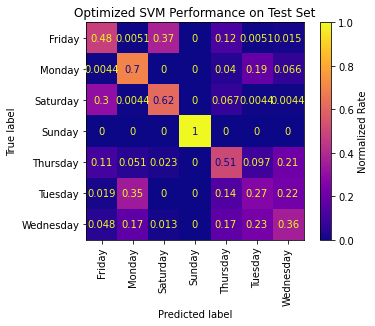

In [31]:
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
cm = ConfusionMatrixDisplay.from_estimator(optimized_svm,
                                           x_test,
                                           y_test,
                                           normalize="true",
                                           cmap = plt.cm.plasma,
                                           xticks_rotation="vertical",
                                           colorbar=False)
cm.ax_.set_title("Optimized SVM Performance on Test Set")
cb = cm.figure_.colorbar(mappable=cm.im_,label="Normalized Rate")

### Making classification report

In [32]:
y_preds=optimized_svm.predict(x_test)
print(len(y_test))
print(len(x_test))

1531
1531


In [33]:
print("OPTIMIZED PARAMETERS:")
print("\tkernel =",optimal_params['kernel'])
print("\tgamma =",optimal_params['gamma'])
print("\tC =",optimal_params['C'],'\n')
print("TEST SET REPORT:")
print(classification_report(y_test,y_preds))

OPTIMIZED PARAMETERS:
	kernel = rbf
	gamma = 0.00018022173678741978
	C = 10.838573202243223 

TEST SET REPORT:
              precision    recall  f1-score   support

      Friday       0.47      0.48      0.47       198
      Monday       0.56      0.70      0.62       227
    Saturday       0.63      0.62      0.62       225
      Sunday       1.00      1.00      1.00       221
    Thursday       0.49      0.51      0.50       217
     Tuesday       0.33      0.27      0.30       214
   Wednesday       0.42      0.36      0.39       229

    accuracy                           0.57      1531
   macro avg       0.56      0.56      0.56      1531
weighted avg       0.56      0.57      0.56      1531



### Making a confision matrix on pooled target labels
- Easy = Mon andTues
- Moderate = Weds and Thurs
- Hard = Fri and Sat
- Sunday

In [34]:
# function to pool target labels
def pool_labels(labels):
  for i,l in enumerate(labels):
    if l in ["Monday", "Tuesday"]:
      labels[i] = "Easy"
    elif l in ["Wednesday", "Thursday"]:
      labels[i] = "Moderate"
    elif l in ["Friday", "Saturday"]:
      labels[i] = "Hard"
  return labels

In [35]:
np.array(y_preds)

array(['Friday', 'Friday', 'Sunday', ..., 'Tuesday', 'Wednesday',
       'Tuesday'], dtype=object)

In [36]:
print(len(y_preds))
print(len(y_test))
print(len(pool_labels(y_preds)))
print(len(pool_labels(np.array(y_test))))

1531
1531
1531
1531


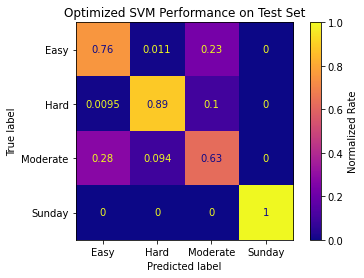

In [37]:
pooled_cm = ConfusionMatrixDisplay.from_predictions(pool_labels(np.array(y_test)),
                                                    pool_labels(y_preds),
                                                    normalize="true",
                                                    cmap = plt.cm.plasma,
                                                    xticks_rotation="horizontal",
                                                    colorbar=False)
pooled_cm.ax_.set_title("Optimized SVM Performance on Test Set")
pooled_cb = pooled_cm.figure_.colorbar(mappable=cm.im_,label="Normalized Rate")

### Classification report on pooled target labels

In [38]:
print("OPTIMIZED PARAMETERS:")
print("\tkernel =",optimal_params['kernel'])
print("\tgamma =",optimal_params['gamma'])
print("\tC =",optimal_params['C'],'\n')
print("TEST SET REPORT:")
print(classification_report(pool_labels(np.array(y_test)),pool_labels(y_preds)))

OPTIMIZED PARAMETERS:
	kernel = rbf
	gamma = 0.00018022173678741978
	C = 10.838573202243223 

TEST SET REPORT:
              precision    recall  f1-score   support

        Easy       0.72      0.76      0.74       441
        Hard       0.89      0.89      0.89       423
    Moderate       0.66      0.63      0.64       446
      Sunday       1.00      1.00      1.00       221

    accuracy                           0.79      1531
   macro avg       0.82      0.82      0.82      1531
weighted avg       0.79      0.79      0.79      1531



### Retraining model on pooled target labels

#### RandomSearchCV with pooled target labels
No need to run more than once - took about 5-10 minutes

In [39]:
# model = RandomizedSearchCV(estimator = svm, param_distributions=param_grid, cv = cross_val, n_iter=10, verbose=1)
# cv = cross_validate(model, X=x_test, y=pool_labels(np.array(y_test)), cv=cross_val, verbose = 1, return_train_score=True, return_estimator=True)

In [40]:
# # we will loop through our models and pick the best one
# test_scores=[]
# for model in cv['estimator']:
# test_scores.append(model.score(x_test,pool_labels(np.array(y_test))))
# best_pooled_model = cv['estimator'][test_scores.index(max(test_scores))]
# print("Best validation accuracy from model with optimal paramters:", max(test_scores))]]

In [41]:
# print("OPTIMAL Pooled SVM PARAMETERS:")
# optimal_pooled_params=best_pooled_model.best_params_
# print(optimal_pooled_params)
# print("Accuracy on test set:")
# print(best_pooled_model.score(x_test,pool_labels(np.array(y_test))))

In [42]:
# OPTIMAL POOLED SVM PARAMETERS:
optimal_pooled_params={'C': 8.104847330840652, 'degree': 2, 'gamma': 0.00014640514398050753, 'kernel': 'rbf'}
# Accuracy on test set:
# 0.8079686479425212

#### Fitting Pooled SVM Model

In [43]:
# creating a seperate model with optimized hyperparamters
optimized_pooled_svm = SVC(C=optimal_pooled_params['C'], kernel=optimal_pooled_params['kernel'], gamma=optimal_pooled_params['gamma'])
optimized_pooled_svm.fit(x_train,pool_labels(np.array(y_train)))

SVC(C=8.104847330840652, gamma=0.00014640514398050753)

In [44]:
# somehow the accuracy is less when we create a new model with the optimal hyperparameters - maybe because no CV is involved?
optimized_pooled_svm.score(x_test,pool_labels(np.array(y_test)))

0.7955584585238407

#### Pooled-trained confusion matrix

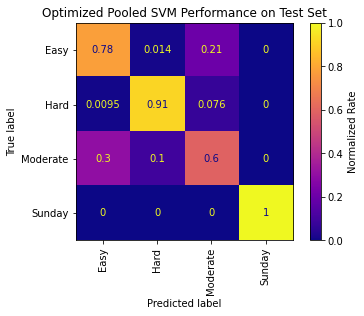

In [45]:
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
cm = ConfusionMatrixDisplay.from_estimator(optimized_pooled_svm,
                                           x_test,
                                           pool_labels(np.array(y_test)),
                                           normalize="true",
                                           cmap = plt.cm.plasma,
                                           xticks_rotation="vertical",
                                           colorbar=False)
cm.ax_.set_title("Optimized Pooled SVM Performance on Test Set")
cb = cm.figure_.colorbar(mappable=cm.im_,label="Normalized Rate")

#### Pooled-trained SVM report

In [46]:
print("OPTIMIZED PARAMETERS:")
print("\tkernel =",optimal_pooled_params['kernel'])
print("\tgamma =",optimal_pooled_params['gamma'])
print("\tC =",optimal_pooled_params['C'],'\n')
print("TEST SET REPORT:")
print(classification_report(pool_labels(np.array(y_test)),pool_labels(y_preds)))

OPTIMIZED PARAMETERS:
	kernel = rbf
	gamma = 0.00014640514398050753
	C = 8.104847330840652 

TEST SET REPORT:
              precision    recall  f1-score   support

        Easy       0.72      0.76      0.74       441
        Hard       0.89      0.89      0.89       423
    Moderate       0.66      0.63      0.64       446
      Sunday       1.00      1.00      1.00       221

    accuracy                           0.79      1531
   macro avg       0.82      0.82      0.82      1531
weighted avg       0.79      0.79      0.79      1531



In [47]:
# looks like that in terms of accuracy, it doesn't matter whether we train the model with pooled target labels or do the pooling afterwards

In [48]:
# Feature importance
perm_importance = permutation_importance(optimized_svm, x_test, y_test)

feature_names = list(x_test.columns)
features = np.array(feature_names)

Text(0.5, 0, 'Permutation Importance')

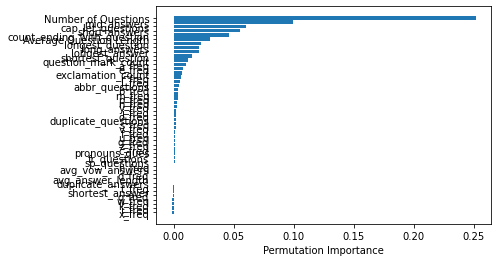

In [49]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

Text(0.5, 0, 'Permutation Importance')

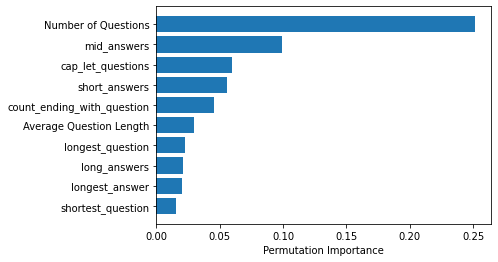

In [50]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx][-10:], perm_importance.importances_mean[sorted_idx[-10:]])
plt.xlabel("Permutation Importance")